**簡単な説明**

先にMLbot_1のコードを読んだ方が理解しやすい．  
概要としては，MLbot_1においてlightGBMを用いてリターン(y_buyとy_sell)を予測していたのを，LSTM+FCNNというニューラルネットワーク構造で予測するという内容．

- In[1] ライブラリのimport
- In[2] dataset(pytorchのdataloaderを使うために必要なもの)とモデル(ネットワークの構成を決めるもの)のclassを定義
- In[3] tableデータにMLbot_1と同様の処理(前処理無しだと全く学習しなかったので雑な前処理だけは入れた)を行ってリターンの列を追加．さらにLSTMに入力可能なデータ形式に加工．
- In[4] 1エポック分の学習部分と検証部分を関数化
- In[5] buy方向モデルの学習パート．In[2]で作ったclassを用いてモデルとモデルに入力するデータを作り，指定したエポックだけ学習と検証を行う(In[4]の関数を使う)．損失(予測したリターンと正しいリターンの平均二乗誤差)と精度(リターンについてTrue Positiveの割合%)の学習過程をグラフに図示する．
- In[6] sell方向モデルの学習パート．In[5]と同様．
- In[7] 学習済みのモデルを用いて，全データ(訓練データ+検証データ+テストデータ)に対するリターンの予測値を求める．リターンyの予測値が0より大きい場合に注文を入れたとして，全データに対する累積リターンを図示する

**改良の余地がある部分**

MLbot_1と共通の部分
- 特徴量の前処理
- 特徴量を増やす(そもそも取得するデータを増やす or 今あるデータを加工してかさ増しする)
- 執行方法を工夫する(今回は手数料が高い成行決済を用いている + 同じ方向の注文が連続しても毎回決済しているので手数料が多い)
- ハイパーパラメータ(ネットワークの入出力データの次元，ネットワークの層数，その他参考になる値がないパラメータ等)を最適化する
-  hold-out以外のバリデーションを用いる
- 問題設定の変更(リターンyの回帰予測ではなく，リターンyが正か負のどちらを取るかの二値分類とするとか)
- 注文条件の変更(リターンyが0より大きい場合に注文ではなく，100より大きい場合に注文とすることで負けにくくするとか)

NNbot_1独自の部分
- ネットワークの構成を変える
- 重みの初期化の実装
- 正則化の実装
- DropOutの実装
- EarlyStoppingの実装

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# classの定義

# dataset class
class MyDataset(Dataset):
    def __init__(self, features, y):
        super(MyDataset, self).__init__()
        self.features = features
        self.y = y
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx]), torch.tensor(self.y[idx])

# model
class LSTM_Linear(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(LSTM_Linear, self).__init__()
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=inputDim, hidden_size=hiddenDim, num_layers=2, batch_first=True)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
    
    def forward(self, inputs):
        output, (hidden, cell) = self.lstm(inputs)
        output = self.output_layer(output[:,-1,:])
        return output

In [3]:
# 特徴量エンジニアリング

# 欠損値を指定してdata.csvを読み込む
df = pd.read_csv('../Record/60/data.csv', index_col=0, na_values='#####')
df = df.astype('float32')

# 欠損値を前後の値から線形補完
df.interpolate(limit_direction='both', inplace=True)

# リターンyをdataframeに追加
# df['fee'] = (df['closeprice'] + (df['closeprice'] - df['closeprice'].diff(-1)))*0.00036←手数料を考慮する場合
df['fee'] = (df['closeprice'] + (df['closeprice'] - df['closeprice'].diff(-1)))*0
df['y_buy'] = (-1) * df['closeprice'].diff(-1) - df['fee']
df['y_sell'] = df['closeprice'].diff(-1) - df['fee']

# 一番下の列はリターンyが定義できないので消去
df.dropna(inplace = True)

# 特徴量として使う列を標準化(平均0，分散と標準変化が1になるようにする)←雑な前処理なので変えた方が良い
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)
features_col = df.columns.values[1:-3]
df[features_col] = mean_norm(df[features_col])

# 時系列データの[x1,x2,x3,...,x_10],[x2,x3,x4,...,x11],[x3,x4,x5,...,x12],...を作る
sequence = 10
features = np.array([df[i:i+sequence][features_col] for i in range((len(df)+1)-sequence)])
y_buy = np.array([df[i:i+sequence]['y_buy'] for i in range((len(df)+1)-sequence)])
y_buy = y_buy.reshape(y_buy.shape[0],y_buy.shape[1],-1)
y_sell = np.array([df[i:i+sequence]['y_sell'] for i in range((len(df)+1)-sequence)])
y_sell = y_sell.reshape(y_sell.shape[0],y_sell.shape[1],-1)

In [4]:
# 学習と検証部分を関数化

def train(model):
    model.train()

    running_loss = 0
    training_accuracy = 0
    count = 0.001

    for inputs, y in trainloader:
        optimizer.zero_grad()
        pred_y = model(inputs)
        loss = criterion(pred_y, y[:, -1, :])
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            running_loss += loss.item()
            # training_accuracy：「リターンyの予測が正でかつ実際の予測が正」である場合の数，count：「リターンyの予測が正」である場合の数
            training_accuracy += torch.sum((pred_y > 0) & (y[:, -1, :] > 0)).item()
            count += torch.sum((pred_y > 0)).item()
    
    # 学習データに対する損失とTrue Positiveの割合%を返す
    return running_loss / len(trainloader), training_accuracy / count * 100


def valid(model):
    model.eval()

    running_loss = 0
    valid_accuracy = 0
    count = 0.001

    for inputs, y in validloader:
        pred_y = model(inputs)
        loss = criterion(pred_y, y[:, -1, :])

        with torch.no_grad():
            running_loss += loss.item()
            # valid_accuracy：「リターンyの予測が正でかつ実際の予測が正」である場合の数，count：「リターンyの予測が正」である場合の数
            valid_accuracy += torch.sum((pred_y > 0) & (y[:, -1, :] > 0)).item()
            count += torch.sum((pred_y > 0)).item()
    
    # 検証データに対する損失とTrue Positiveの割合%を返す
    return running_loss / len(validloader), valid_accuracy / count * 100

--------------------------------------------------
Epoch is 1
training_loss is 83934.71203399122
training_accuracy(%) is 0.0
valid_loss is 102380.328125
valid_accuracy(%) is 0.0
--------------------------------------------------
Epoch is 2
training_loss is 83826.93225740132
training_accuracy(%) is 0.0
valid_loss is 109362.92801339286
valid_accuracy(%) is 0.0
--------------------------------------------------
Epoch is 3
training_loss is 83240.10476631031
training_accuracy(%) is 49.99500049995001
valid_loss is 109481.84151785714
valid_accuracy(%) is 64.7020763484501
--------------------------------------------------
Epoch is 4
training_loss is 83656.98183936403
training_accuracy(%) is 54.95190111213702
valid_loss is 109458.80301339286
valid_accuracy(%) is 47.61791385919382
--------------------------------------------------
Epoch is 5
training_loss is 83851.5040433114
training_accuracy(%) is 53.98218145535076
valid_loss is 109049.86495535714
valid_accuracy(%) is 51.85121171343563
--------

--------------------------------------------------
Epoch is 41
training_loss is 79377.08353892544
training_accuracy(%) is 63.26950473565874
valid_loss is 112899.95982142857
valid_accuracy(%) is 51.40138877206755
--------------------------------------------------
Epoch is 42
training_loss is 79383.32582922149
training_accuracy(%) is 63.2528850343674
valid_loss is 103750.98995535714
valid_accuracy(%) is 53.703206451792106
--------------------------------------------------
Epoch is 43
training_loss is 79274.6814350329
training_accuracy(%) is 62.8629401183815
valid_loss is 111972.29464285714
valid_accuracy(%) is 53.718564309385876
--------------------------------------------------
Epoch is 44
training_loss is 79356.17835115132
training_accuracy(%) is 62.015383691116874
valid_loss is 111322.08537946429
valid_accuracy(%) is 52.426675469170206
--------------------------------------------------
Epoch is 45
training_loss is 78520.29487047698
training_accuracy(%) is 63.84603106532488
valid_loss 

--------------------------------------------------
Epoch is 80
training_loss is 71518.19627192983
training_accuracy(%) is 68.30588651022494
valid_loss is 115420.1484375
valid_accuracy(%) is 53.77307761247535
--------------------------------------------------
Epoch is 81
training_loss is 71836.36182497258
training_accuracy(%) is 66.79092016619373
valid_loss is 115731.74665178571
valid_accuracy(%) is 53.703206451792106
--------------------------------------------------
Epoch is 82
training_loss is 71911.04937637062
training_accuracy(%) is 68.306952151669
valid_loss is 116507.11495535714
valid_accuracy(%) is 53.63587603749057
--------------------------------------------------
Epoch is 83
training_loss is 70514.92297149122
training_accuracy(%) is 67.15051333845129
valid_loss is 117171.87611607143
valid_accuracy(%) is 53.98182316970646
--------------------------------------------------
Epoch is 84
training_loss is 73100.17735745614
training_accuracy(%) is 66.86377344423384
valid_loss is 112

--------------------------------------------------
Epoch is 119
training_loss is 71105.8612595943
training_accuracy(%) is 66.42456184290046
valid_loss is 117961.18136160714
valid_accuracy(%) is 55.91337727551316
--------------------------------------------------
Epoch is 120
training_loss is 69997.69090940242
training_accuracy(%) is 66.6032891778194
valid_loss is 116900.14229910714
valid_accuracy(%) is 54.4438395128943
--------------------------------------------------
Epoch is 121
training_loss is 70776.16553591008
training_accuracy(%) is 67.91732098063606
valid_loss is 116149.24162946429
valid_accuracy(%) is 53.84556213667982
--------------------------------------------------
Epoch is 122
training_loss is 73584.2459566886
training_accuracy(%) is 63.73228216147508
valid_loss is 120824.18638392857
valid_accuracy(%) is 49.99943182463835
--------------------------------------------------
Epoch is 123
training_loss is 71878.6824801261
training_accuracy(%) is 66.3618530861918
valid_loss is

--------------------------------------------------
Epoch is 158
training_loss is 69366.32500685308
training_accuracy(%) is 67.09546489804247
valid_loss is 117737.546875
valid_accuracy(%) is 58.90330269448363
--------------------------------------------------
Epoch is 159
training_loss is 66728.93616365132
training_accuracy(%) is 69.26056564092288
valid_loss is 111436.78404017857
valid_accuracy(%) is 53.085764373279346
--------------------------------------------------
Epoch is 160
training_loss is 66693.56222587719
training_accuracy(%) is 69.34852615224875
valid_loss is 118837.98772321429
valid_accuracy(%) is 53.423925699647945
--------------------------------------------------
Epoch is 161
training_loss is 65602.91560444079
training_accuracy(%) is 70.42787854498339
valid_loss is 118926.57924107143
valid_accuracy(%) is 54.05332360373508
--------------------------------------------------
Epoch is 162
training_loss is 64772.32260827851
training_accuracy(%) is 71.4002536484149
valid_loss 

--------------------------------------------------
Epoch is 197
training_loss is 64549.860882675435
training_accuracy(%) is 71.04233389510831
valid_loss is 124587.18973214286
valid_accuracy(%) is 52.85638776588905
--------------------------------------------------
Epoch is 198
training_loss is 64674.43184621711
training_accuracy(%) is 69.90462875308809
valid_loss is 122772.08370535714
valid_accuracy(%) is 52.1731569107694
--------------------------------------------------
Epoch is 199
training_loss is 62432.178882264256
training_accuracy(%) is 72.32308621598744
valid_loss is 122790.65457589286
valid_accuracy(%) is 55.71348980728846
--------------------------------------------------
Epoch is 200
training_loss is 61907.43218887061
training_accuracy(%) is 72.3998552002896
valid_loss is 123369.14927455357
valid_accuracy(%) is 56.16361419706579
--------------------------------------------------
Epoch is 201
training_loss is 62303.6895216557
training_accuracy(%) is 73.72693741967939
valid_lo

--------------------------------------------------
Epoch is 236
training_loss is 66183.18335389254
training_accuracy(%) is 69.200644833051
valid_loss is 125193.15569196429
valid_accuracy(%) is 55.12749836540557
--------------------------------------------------
Epoch is 237
training_loss is 64891.81584087171
training_accuracy(%) is 70.57640044453193
valid_loss is 120378.39006696429
valid_accuracy(%) is 55.26243075749003
--------------------------------------------------
Epoch is 238
training_loss is 63646.49604235197
training_accuracy(%) is 71.09361114529074
valid_loss is 122069.88504464286
valid_accuracy(%) is 55.84343060479734
--------------------------------------------------
Epoch is 239
training_loss is 62651.92321134869
training_accuracy(%) is 71.8198203134632
valid_loss is 123102.92131696429
valid_accuracy(%) is 57.49928125898426
--------------------------------------------------
Epoch is 240
training_loss is 64143.05019873904
training_accuracy(%) is 71.08896814065714
valid_loss

--------------------------------------------------
Epoch is 275
training_loss is 61158.42937911184
training_accuracy(%) is 72.97815980639092
valid_loss is 120958.59040178571
valid_accuracy(%) is 58.74926563417957
--------------------------------------------------
Epoch is 276
training_loss is 60724.081191748905
training_accuracy(%) is 73.3998532002936
valid_loss is 121224.21484375
valid_accuracy(%) is 60.97486616016877
--------------------------------------------------
Epoch is 277
training_loss is 63195.2725294682
training_accuracy(%) is 71.39944949401725
valid_loss is 119876.21707589286
valid_accuracy(%) is 58.33263889715599
--------------------------------------------------
Epoch is 278
training_loss is 66940.45237116228
training_accuracy(%) is 71.39944949401725
valid_loss is 119690.45758928571
valid_accuracy(%) is 56.16361419706579
--------------------------------------------------
Epoch is 279
training_loss is 64136.72820723684
training_accuracy(%) is 70.65854159971737
valid_loss 

--------------------------------------------------
Epoch is 314
training_loss is 60913.790021929824
training_accuracy(%) is 71.34489016590612
valid_loss is 126705.27008928571
valid_accuracy(%) is 58.22711104922722
--------------------------------------------------
Epoch is 315
training_loss is 61715.68513569079
training_accuracy(%) is 71.23795954674372
valid_loss is 125644.390625
valid_accuracy(%) is 58.62001586188664
--------------------------------------------------
Epoch is 316
training_loss is 62529.74599095395
training_accuracy(%) is 71.77404884264347
valid_loss is 131477.07142857142
valid_accuracy(%) is 58.535871513762025
--------------------------------------------------
Epoch is 317
training_loss is 62968.92828262061
training_accuracy(%) is 71.9006778911614
valid_loss is 125693.42466517857
valid_accuracy(%) is 58.02397501265416
--------------------------------------------------
Epoch is 318
training_loss is 61058.581380208336
training_accuracy(%) is 70.8909487307946
valid_loss 

--------------------------------------------------
Epoch is 353
training_loss is 58697.38959703947
training_accuracy(%) is 71.0057771089209
valid_loss is 125067.04352678571
valid_accuracy(%) is 55.81330449645934
--------------------------------------------------
Epoch is 354
training_loss is 57566.32745682566
training_accuracy(%) is 73.38862081367814
valid_loss is 123708.63560267857
valid_accuracy(%) is 55.17177963471684
--------------------------------------------------
Epoch is 355
training_loss is 56750.060050027416
training_accuracy(%) is 73.09306548079347
valid_loss is 125917.16517857143
valid_accuracy(%) is 52.68760550961817
--------------------------------------------------
Epoch is 356
training_loss is 56300.909316748905
training_accuracy(%) is 72.48981427748137
valid_loss is 126310.99720982143
valid_accuracy(%) is 55.43418006326017
--------------------------------------------------
Epoch is 357
training_loss is 58232.7264939693
training_accuracy(%) is 73.14995105718593
valid_l

--------------------------------------------------
Epoch is 392
training_loss is 66920.39651864035
training_accuracy(%) is 67.68940850287274
valid_loss is 125450.43080357143
valid_accuracy(%) is 57.953886887649
--------------------------------------------------
Epoch is 393
training_loss is 64531.51245545504
training_accuracy(%) is 65.77049145073217
valid_loss is 122624.82366071429
valid_accuracy(%) is 58.82283737838379
--------------------------------------------------
Epoch is 394
training_loss is 61328.453296326756
training_accuracy(%) is 69.72097665144094
valid_loss is 123188.62611607143
valid_accuracy(%) is 59.035433308032424
--------------------------------------------------
Epoch is 395
training_loss is 60962.56863349781
training_accuracy(%) is 69.77673473278959
valid_loss is 126979.99051339286
valid_accuracy(%) is 56.32119171044011
--------------------------------------------------
Epoch is 396
training_loss is 62461.461417214916
training_accuracy(%) is 69.30488551180403
valid_

--------------------------------------------------
Epoch is 431
training_loss is 58326.74928042763
training_accuracy(%) is 69.81468552836013
valid_loss is 134387.78236607142
valid_accuracy(%) is 53.19092350081382
--------------------------------------------------
Epoch is 432
training_loss is 58032.88145901864
training_accuracy(%) is 72.11524593221937
valid_loss is 125321.70758928571
valid_accuracy(%) is 56.46992388324843
--------------------------------------------------
Epoch is 433
training_loss is 56692.138500548244
training_accuracy(%) is 70.79289982030983
valid_loss is 129187.32142857143
valid_accuracy(%) is 54.11701038811307
--------------------------------------------------
Epoch is 434
training_loss is 58913.60378974781
training_accuracy(%) is 69.88403497290547
valid_loss is 129806.44866071429
valid_accuracy(%) is 53.487750142440206
--------------------------------------------------
Epoch is 435
training_loss is 57613.44623766447
training_accuracy(%) is 70.81698284633687
valid

--------------------------------------------------
Epoch is 470
training_loss is 57323.14545641447
training_accuracy(%) is 71.2849974196839
valid_loss is 125414.81808035714
valid_accuracy(%) is 59.035433308032424
--------------------------------------------------
Epoch is 471
training_loss is 58382.717756304824
training_accuracy(%) is 69.70283227161926
valid_loss is 127500.46428571429
valid_accuracy(%) is 58.02397501265416
--------------------------------------------------
Epoch is 472
training_loss is 58004.25642475329
training_accuracy(%) is 69.56507991090926
valid_loss is 125459.54185267857
valid_accuracy(%) is 56.97608167346891
--------------------------------------------------
Epoch is 473
training_loss is 57639.51480263158
training_accuracy(%) is 69.93973959972024
valid_loss is 126000.58705357143
valid_accuracy(%) is 57.31637419055865
--------------------------------------------------
Epoch is 474
training_loss is 59982.247721354164
training_accuracy(%) is 69.24551403188775
valid

--------------------------------------------------
Epoch is 509
training_loss is 60473.62705592105
training_accuracy(%) is 69.762707978838
valid_loss is 127738.89174107143
valid_accuracy(%) is 55.55478396133387
--------------------------------------------------
Epoch is 510
training_loss is 62873.02682976974
training_accuracy(%) is 68.79831628233279
valid_loss is 118594.89732142857
valid_accuracy(%) is 57.53345844577471
--------------------------------------------------
Epoch is 511
training_loss is 65131.55674342105
training_accuracy(%) is 66.48733604420065
valid_loss is 121276.95535714286
valid_accuracy(%) is 56.755989783921834
--------------------------------------------------
Epoch is 512
training_loss is 63233.11410361842
training_accuracy(%) is 67.57729038744921
valid_loss is 128754.97879464286
valid_accuracy(%) is 56.94365356036721
--------------------------------------------------
Epoch is 513
training_loss is 64011.41772889254
training_accuracy(%) is 67.52755068717585
valid_lo

--------------------------------------------------
Epoch is 548
training_loss is 57888.38214432566
training_accuracy(%) is 69.62251014620728
valid_loss is 123361.63895089286
valid_accuracy(%) is 59.70060148355994
--------------------------------------------------
Epoch is 549
training_loss is 56405.278029057015
training_accuracy(%) is 70.30637872341241
valid_loss is 121538.16350446429
valid_accuracy(%) is 58.90330269448363
--------------------------------------------------
Epoch is 550
training_loss is 58129.568188048244
training_accuracy(%) is 70.48530002854363
valid_loss is 124604.61495535714
valid_accuracy(%) is 58.20808644647094
--------------------------------------------------
Epoch is 551
training_loss is 60128.94616913377
training_accuracy(%) is 69.01127564396265
valid_loss is 122188.2265625
valid_accuracy(%) is 63.23436420052646
--------------------------------------------------
Epoch is 552
training_loss is 60114.07558936404
training_accuracy(%) is 68.70357647485838
valid_los

--------------------------------------------------
Epoch is 587
training_loss is 56709.32529810855
training_accuracy(%) is 68.1414723159782
valid_loss is 130581.07589285714
valid_accuracy(%) is 59.72139275843391
--------------------------------------------------
Epoch is 588
training_loss is 56020.444044682015
training_accuracy(%) is 69.13781183135892
valid_loss is 131691.3013392857
valid_accuracy(%) is 57.89397507927527
--------------------------------------------------
Epoch is 589
training_loss is 56054.80472176535
training_accuracy(%) is 70.39698484298765
valid_loss is 134321.3828125
valid_accuracy(%) is 55.69549752534778
--------------------------------------------------
Epoch is 590
training_loss is 56160.10495476974
training_accuracy(%) is 69.21756935787525
valid_loss is 132265.2377232143
valid_accuracy(%) is 56.755989783921834
--------------------------------------------------
Epoch is 591
training_loss is 56667.546223958336
training_accuracy(%) is 69.37704260027232
valid_loss 

--------------------------------------------------
Epoch is 626
training_loss is 55062.1953125
training_accuracy(%) is 67.81399687780227
valid_loss is 132847.68638392858
valid_accuracy(%) is 57.89397507927527
--------------------------------------------------
Epoch is 627
training_loss is 56505.492684347584
training_accuracy(%) is 68.07326959033104
valid_loss is 133696.2265625
valid_accuracy(%) is 57.53345844577471
--------------------------------------------------
Epoch is 628
training_loss is 58606.56287691886
training_accuracy(%) is 67.82596899831479
valid_loss is 132777.20926339287
valid_accuracy(%) is 57.14211503746704
--------------------------------------------------
Epoch is 629
training_loss is 57218.5879591557
training_accuracy(%) is 67.5578118399076
valid_loss is 132780.35770089287
valid_accuracy(%) is 59.45865596410859
--------------------------------------------------
Epoch is 630
training_loss is 55175.710132264256
training_accuracy(%) is 70.62030908702721
valid_loss is 1

--------------------------------------------------
Epoch is 665
training_loss is 59370.26452850877
training_accuracy(%) is 68.61990809091098
valid_loss is 133478.11160714287
valid_accuracy(%) is 58.332523159400566
--------------------------------------------------
Epoch is 666
training_loss is 61963.51437431469
training_accuracy(%) is 69.06173839972377
valid_loss is 137555.79520089287
valid_accuracy(%) is 54.66593778749617
--------------------------------------------------
Epoch is 667
training_loss is 60825.72892680921
training_accuracy(%) is 67.91325213926744
valid_loss is 134999.80580357142
valid_accuracy(%) is 59.15409642117716
--------------------------------------------------
Epoch is 668
training_loss is 60583.77347176535
training_accuracy(%) is 69.26056564092288
valid_loss is 140273.75669642858
valid_accuracy(%) is 54.32031703312305
--------------------------------------------------
Epoch is 669
training_loss is 59085.46618009869
training_accuracy(%) is 70.51026368570193
valid_

--------------------------------------------------
Epoch is 704
training_loss is 58089.76733826754
training_accuracy(%) is 67.19564868492296
valid_loss is 141736.86049107142
valid_accuracy(%) is 51.723543407547034
--------------------------------------------------
Epoch is 705
training_loss is 56924.86436060855
training_accuracy(%) is 69.1334492176007
valid_loss is 140465.86049107142
valid_accuracy(%) is 54.76125284222807
--------------------------------------------------
Epoch is 706
training_loss is 55314.47108004386
training_accuracy(%) is 68.67018457161281
valid_loss is 142275.1484375
valid_accuracy(%) is 55.95171486053737
--------------------------------------------------
Epoch is 707
training_loss is 55849.87957442434
training_accuracy(%) is 70.10663682093093
valid_loss is 127835.7109375
valid_accuracy(%) is 55.29346713568075
--------------------------------------------------
Epoch is 708
training_loss is 58282.10281318531
training_accuracy(%) is 67.26606606822651
valid_loss is 1

--------------------------------------------------
Epoch is 743
training_loss is 62567.64869449013
training_accuracy(%) is 66.4091382062969
valid_loss is 142485.32979910713
valid_accuracy(%) is 55.26243075749003
--------------------------------------------------
Epoch is 744
training_loss is 63746.97375274123
training_accuracy(%) is 66.46327954617979
valid_loss is 130110.46428571429
valid_accuracy(%) is 58.332523159400566
--------------------------------------------------
Epoch is 745
training_loss is 64726.64758086623
training_accuracy(%) is 66.35148137716186
valid_loss is 135987.4375
valid_accuracy(%) is 55.26243075749003
--------------------------------------------------
Epoch is 746
training_loss is 63107.716659813595
training_accuracy(%) is 67.17544432167114
valid_loss is 136434.50558035713
valid_accuracy(%) is 56.78942235281046
--------------------------------------------------
Epoch is 747
training_loss is 63086.635725054824
training_accuracy(%) is 67.82260535143479
valid_loss i

--------------------------------------------------
Epoch is 782
training_loss is 57964.414542214916
training_accuracy(%) is 68.4998858335236
valid_loss is 148403.3560267857
valid_accuracy(%) is 56.62582378525559
--------------------------------------------------
Epoch is 783
training_loss is 56510.69551809211
training_accuracy(%) is 70.21647975364665
valid_loss is 145431.56138392858
valid_accuracy(%) is 55.99925334328876
--------------------------------------------------
Epoch is 784
training_loss is 55387.31013569079
training_accuracy(%) is 71.32339830257666
valid_loss is 141530.24441964287
valid_accuracy(%) is 56.578202918382644
--------------------------------------------------
Epoch is 785
training_loss is 57166.35229920504
training_accuracy(%) is 69.85546957496467
valid_loss is 143033.92745535713
valid_accuracy(%) is 54.66593778749617
--------------------------------------------------
Epoch is 786
training_loss is 55108.239120751095
training_accuracy(%) is 69.13568053671864
valid_

--------------------------------------------------
Epoch is 821
training_loss is 60276.107421875
training_accuracy(%) is 67.53234224055244
valid_loss is 140110.46986607142
valid_accuracy(%) is 52.85638776588905
--------------------------------------------------
Epoch is 822
training_loss is 60578.26989103619
training_accuracy(%) is 67.36628365213045
valid_loss is 146325.55747767858
valid_accuracy(%) is 55.40465669382846
--------------------------------------------------
Epoch is 823
training_loss is 59665.82497258772
training_accuracy(%) is 68.1450239011615
valid_loss is 139122.24776785713
valid_accuracy(%) is 56.337234686835394
--------------------------------------------------
Epoch is 824
training_loss is 60267.86742735746
training_accuracy(%) is 68.29255479820864
valid_loss is 134373.89676339287
valid_accuracy(%) is 53.94665859659741
--------------------------------------------------
Epoch is 825
training_loss is 58880.84044339364
training_accuracy(%) is 68.71495583807106
valid_los

--------------------------------------------------
Epoch is 860
training_loss is 57228.47003495066
training_accuracy(%) is 68.57131332552383
valid_loss is 161609.38839285713
valid_accuracy(%) is 55.05556117346996
--------------------------------------------------
Epoch is 861
training_loss is 55994.25839501096
training_accuracy(%) is 67.10952307388195
valid_loss is 155749.74441964287
valid_accuracy(%) is 55.29346713568075
--------------------------------------------------
Epoch is 862
training_loss is 56115.62571957237
training_accuracy(%) is 69.36015259233571
valid_loss is 153511.2533482143
valid_accuracy(%) is 53.01140950109035
--------------------------------------------------
Epoch is 863
training_loss is 58120.45172012061
training_accuracy(%) is 67.98611362114696
valid_loss is 152409.9330357143
valid_accuracy(%) is 55.29346713568075
--------------------------------------------------
Epoch is 864
training_loss is 58754.61526864035
training_accuracy(%) is 66.55220145419992
valid_los

--------------------------------------------------
Epoch is 899
training_loss is 55189.74508292215
training_accuracy(%) is 70.27013461363974
valid_loss is 136785.45535714287
valid_accuracy(%) is 54.544834717787296
--------------------------------------------------
Epoch is 900
training_loss is 54640.67035019189
training_accuracy(%) is 67.49543961733639
valid_loss is 136470.2299107143
valid_accuracy(%) is 58.535871513762025
--------------------------------------------------
Epoch is 901
training_loss is 53393.855331688595
training_accuracy(%) is 69.34293915522052
valid_loss is 142546.91015625
valid_accuracy(%) is 54.32031703312305
--------------------------------------------------
Epoch is 902
training_loss is 54133.98348410088
training_accuracy(%) is 69.24515236763705
valid_loss is 128414.14620535714
valid_accuracy(%) is 54.429690763408054
--------------------------------------------------
Epoch is 903
training_loss is 53046.9404296875
training_accuracy(%) is 69.57282994158373
valid_lo

--------------------------------------------------
Epoch is 938
training_loss is 60238.7596970943
training_accuracy(%) is 68.6724448275313
valid_loss is 136904.02622767858
valid_accuracy(%) is 55.12749836540557
--------------------------------------------------
Epoch is 939
training_loss is 58155.87616502193
training_accuracy(%) is 68.72714776882223
valid_loss is 146506.4341517857
valid_accuracy(%) is 53.01140950109035
--------------------------------------------------
Epoch is 940
training_loss is 57489.033340186405
training_accuracy(%) is 68.84045499917573
valid_loss is 150241.14955357142
valid_accuracy(%) is 53.332740747325026
--------------------------------------------------
Epoch is 941
training_loss is 57132.339192708336
training_accuracy(%) is 69.90812860893834
valid_loss is 149220.40736607142
valid_accuracy(%) is 53.332740747325026
--------------------------------------------------
Epoch is 942
training_loss is 58365.78371710526
training_accuracy(%) is 67.97740079138428
valid_

--------------------------------------------------
Epoch is 977
training_loss is 57092.88918585526
training_accuracy(%) is 69.98037040863468
valid_loss is 152820.30747767858
valid_accuracy(%) is 52.74667311348227
--------------------------------------------------
Epoch is 978
training_loss is 57794.74605948465
training_accuracy(%) is 68.97797631756146
valid_loss is 160472.08816964287
valid_accuracy(%) is 51.723543407547034
--------------------------------------------------
Epoch is 979
training_loss is 58404.57010690789
training_accuracy(%) is 66.60604971678818
valid_loss is 159217.5357142857
valid_accuracy(%) is 52.94055364054541
--------------------------------------------------
Epoch is 980
training_loss is 57241.87280701754
training_accuracy(%) is 67.32483424625809
valid_loss is 158305.6997767857
valid_accuracy(%) is 52.8729554832703
--------------------------------------------------
Epoch is 981
training_loss is 56582.546429550435
training_accuracy(%) is 70.07155901154299
valid_lo

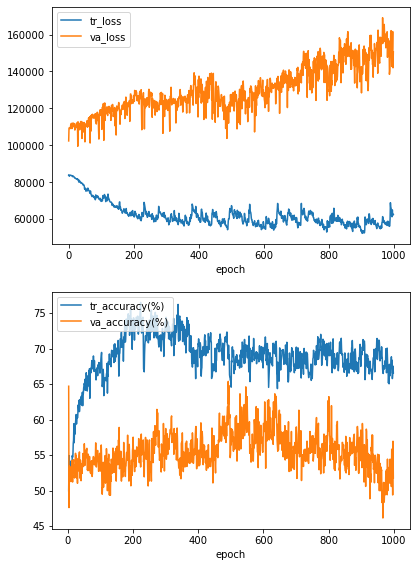

In [5]:
# buy方向モデルの学習

tr_loss_buy = []
tr_acc_buy = []
va_loss_buy = []
va_acc_buy = []

# 特徴量とラベルを[8:1:1]=[学習データ(tr):検証データ(va):テストデータ(te)]の割合で分割
tr_features, va_features, tr_y_buy, va_y_buy = train_test_split(features, y_buy, test_size=0.2, random_state=1, shuffle=False)
va_features, te_features, va_y_buy, te_y_buy = train_test_split(va_features, va_y_buy, test_size=0.5, random_state=1, shuffle=False)

# パラメータ
batchsize = 20
lr = 0.01
epochs = 1000

# 学習データをミニバッチに分割してイテレーターにする
dataset = MyDataset(tr_features, tr_y_buy)
trainloader = DataLoader(dataset, batch_size = batchsize, shuffle=True, drop_last = True)
# 訓練データをミニバッチに分割してイテレーターにする
dataset = MyDataset(va_features, va_y_buy)
validloader = DataLoader(dataset, batch_size = batchsize, shuffle=True, drop_last = True)

# モデル，最適化関数，評価関数を呼び出す
model_buy = LSTM_Linear(inputDim=len(features_col), hiddenDim=5, outputDim=1)
optimizer = optim.Adam(model_buy.parameters(),lr=lr)
criterion = nn.MSELoss()

# 指定したエポック数だけ学習させる．また，学習過程における学習データと検証データの損失とTrue Positiveの割合を表示する．
for epoch in range(1, epochs+1):
    loss, acc = train(model_buy)
    print('--------------------------------------------------')
    print('Epoch is', epoch)
    print('training_loss is', loss)
    print('training_accuracy(%) is', acc)
    tr_loss_buy.append(loss)
    tr_acc_buy.append(acc)

    loss, acc = valid(model_buy)
    print('valid_loss is', loss)
    print('valid_accuracy(%) is', acc)
    va_loss_buy.append(loss)
    va_acc_buy.append(acc)

# 学習過程における学習データと検証データの損失とTrue Positiveの割合を図示する．
fig = plt.figure(figsize=(6.4, 4.8*2))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

x = [i for i in range(epochs)] 
tr_acc_buy = [None if i == 0 else i for i in tr_acc_buy]
va_acc_buy = [None if i == 0 else i for i in va_acc_buy]

ax1.plot(x, tr_loss_buy, label='tr_loss')
ax1.plot(x, va_loss_buy, label='va_loss')
ax2.plot(x, tr_acc_buy, label='tr_accuracy(%)')
ax2.plot(x, va_acc_buy, label='va_accuracy(%)')

ax1.set_xlabel('epoch')
ax2.set_xlabel('epoch')

ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper left')

plt.show()

--------------------------------------------------
Epoch is 1
training_loss is 84100.59834155702
training_accuracy(%) is 49.649079255193634
valid_loss is 111017.76729910714
valid_accuracy(%) is 46.42823979828715
--------------------------------------------------
Epoch is 2
training_loss is 84057.70826480263
training_accuracy(%) is 48.98369005722555
valid_loss is 111013.46595982143
valid_accuracy(%) is 47.142520410568494
--------------------------------------------------
Epoch is 3
training_loss is 83688.44634046052
training_accuracy(%) is 49.73587171138053
valid_loss is 110065.80412946429
valid_accuracy(%) is 52.93806246691371
--------------------------------------------------
Epoch is 4
training_loss is 84005.64566200657
training_accuracy(%) is 51.913391159082934
valid_loss is 110108.56529017857
valid_accuracy(%) is 49.99166805532412
--------------------------------------------------
Epoch is 5
training_loss is 83810.2364651864
training_accuracy(%) is 52.4451054888609
valid_loss is 11

--------------------------------------------------
Epoch is 40
training_loss is 83184.3983689693
training_accuracy(%) is 54.082926261142894
valid_loss is 109592.76841517857
valid_accuracy(%) is 45.99908001839963
--------------------------------------------------
Epoch is 41
training_loss is 83092.51415158992
training_accuracy(%) is 53.639778237831116
valid_loss is 109692.57756696429
valid_accuracy(%) is 49.99875003124921
--------------------------------------------------
Epoch is 42
training_loss is 82919.11636513157
training_accuracy(%) is 53.02190518969068
valid_loss is 110044.43136160714
valid_accuracy(%) is 47.99904001919962
--------------------------------------------------
Epoch is 43
training_loss is 82829.07447574013
training_accuracy(%) is 53.882640439555566
valid_loss is 109838.24832589286
valid_accuracy(%) is 49.12194522903107
--------------------------------------------------
Epoch is 44
training_loss is 83305.15344024122
training_accuracy(%) is 53.12493359383301
valid_loss

--------------------------------------------------
Epoch is 79
training_loss is 80651.1876370614
training_accuracy(%) is 56.728157350715904
valid_loss is 107337.24274553571
valid_accuracy(%) is 48.52869810738077
--------------------------------------------------
Epoch is 80
training_loss is 79513.34697094298
training_accuracy(%) is 57.18008201033681
valid_loss is 109320.60602678571
valid_accuracy(%) is 49.205568165584666
--------------------------------------------------
Epoch is 81
training_loss is 79093.70022957785
training_accuracy(%) is 57.42697953981494
valid_loss is 103732.49386160714
valid_accuracy(%) is 49.29508035098097
--------------------------------------------------
Epoch is 82
training_loss is 79699.15035635965
training_accuracy(%) is 57.51971303467938
valid_loss is 111309.875
valid_accuracy(%) is 46.42801871406292
--------------------------------------------------
Epoch is 83
training_loss is 79582.52244380483
training_accuracy(%) is 58.300055378412516
valid_loss is 1086

--------------------------------------------------
Epoch is 118
training_loss is 73995.89422286184
training_accuracy(%) is 62.142768367473764
valid_loss is 111661.17745535714
valid_accuracy(%) is 45.61323485552885
--------------------------------------------------
Epoch is 119
training_loss is 73378.3653714364
training_accuracy(%) is 62.96820897952596
valid_loss is 114645.93694196429
valid_accuracy(%) is 44.82681333080464
--------------------------------------------------
Epoch is 120
training_loss is 72608.37212171052
training_accuracy(%) is 62.44595331517508
valid_loss is 113635.04520089286
valid_accuracy(%) is 45.16056192642054
--------------------------------------------------
Epoch is 121
training_loss is 73956.60611979167
training_accuracy(%) is 61.53837222297211
valid_loss is 115353.953125
valid_accuracy(%) is 45.31179200324995
--------------------------------------------------
Epoch is 122
training_loss is 74119.00466008772
training_accuracy(%) is 62.62617225660569
valid_loss i

--------------------------------------------------
Epoch is 157
training_loss is 69923.05050712719
training_accuracy(%) is 65.59854030600286
valid_loss is 118410.00446428571
valid_accuracy(%) is 48.275029740866536
--------------------------------------------------
Epoch is 158
training_loss is 70477.30206620066
training_accuracy(%) is 63.44595258300711
valid_loss is 114659.84598214286
valid_accuracy(%) is 46.96898531840426
--------------------------------------------------
Epoch is 159
training_loss is 75986.06996984649
training_accuracy(%) is 59.39384940325848
valid_loss is 115635.0
valid_accuracy(%) is 44.593991973081444
--------------------------------------------------
Epoch is 160
training_loss is 72009.87078536184
training_accuracy(%) is 61.6765543764156
valid_loss is 118103.97377232143
valid_accuracy(%) is 42.46517170997657
--------------------------------------------------
Epoch is 161
training_loss is 71184.66843133223
training_accuracy(%) is 62.65812870549256
valid_loss is 11

--------------------------------------------------
Epoch is 196
training_loss is 65233.24527138158
training_accuracy(%) is 65.77697680223422
valid_loss is 109413.94084821429
valid_accuracy(%) is 45.45385675974606
--------------------------------------------------
Epoch is 197
training_loss is 67705.91824287281
training_accuracy(%) is 65.24476264650451
valid_loss is 119296.64899553571
valid_accuracy(%) is 43.07626036522515
--------------------------------------------------
Epoch is 198
training_loss is 68164.13056811952
training_accuracy(%) is 65.66918792253871
valid_loss is 120593.49888392857
valid_accuracy(%) is 42.646431670122496
--------------------------------------------------
Epoch is 199
training_loss is 67191.99273574562
training_accuracy(%) is 65.33535888920305
valid_loss is 110565.40345982143
valid_accuracy(%) is 44.28508164169083
--------------------------------------------------
Epoch is 200
training_loss is 66300.01990816886
training_accuracy(%) is 67.09459535377952
valid_

--------------------------------------------------
Epoch is 235
training_loss is 65402.896004660084
training_accuracy(%) is 68.92349145227179
valid_loss is 120750.68080357143
valid_accuracy(%) is 45.2821644874625
--------------------------------------------------
Epoch is 236
training_loss is 66042.74640213816
training_accuracy(%) is 69.06462398448923
valid_loss is 117022.92299107143
valid_accuracy(%) is 48.3863163497363
--------------------------------------------------
Epoch is 237
training_loss is 64701.919596354164
training_accuracy(%) is 69.60264317332786
valid_loss is 118505.13504464286
valid_accuracy(%) is 49.20556816558467
--------------------------------------------------
Epoch is 238
training_loss is 64615.817828262065
training_accuracy(%) is 68.18170339780572
valid_loss is 117910.04966517857
valid_accuracy(%) is 49.9990000199996
--------------------------------------------------
Epoch is 239
training_loss is 64102.45309073465
training_accuracy(%) is 69.63338632916872
valid_l

--------------------------------------------------
Epoch is 274
training_loss is 66432.59484649122
training_accuracy(%) is 64.03215478684712
valid_loss is 114214.39787946429
valid_accuracy(%) is 50.94243504839532
--------------------------------------------------
Epoch is 275
training_loss is 66214.77340323465
training_accuracy(%) is 65.25963431877545
valid_loss is 111110.53125
valid_accuracy(%) is 49.99903848002922
--------------------------------------------------
Epoch is 276
training_loss is 66939.4130174068
training_accuracy(%) is 64.42942209828507
valid_loss is 109224.12555803571
valid_accuracy(%) is 46.15295859695006
--------------------------------------------------
Epoch is 277
training_loss is 66848.31996984649
training_accuracy(%) is 64.64801203271352
valid_loss is 120406.64174107143
valid_accuracy(%) is 47.9156684235745
--------------------------------------------------
Epoch is 278
training_loss is 67204.57110060308
training_accuracy(%) is 65.7761840130484
valid_loss is 12

--------------------------------------------------
Epoch is 313
training_loss is 64943.219589501095
training_accuracy(%) is 68.0201894751447
valid_loss is 118082.23995535714
valid_accuracy(%) is 49.055678194751046
--------------------------------------------------
Epoch is 314
training_loss is 63089.46405564693
training_accuracy(%) is 66.71963898146659
valid_loss is 131437.71651785713
valid_accuracy(%) is 45.09715495774592
--------------------------------------------------
Epoch is 315
training_loss is 65704.30509868421
training_accuracy(%) is 64.71508747612741
valid_loss is 130731.55022321429
valid_accuracy(%) is 39.582508697735456
--------------------------------------------------
Epoch is 316
training_loss is 65696.83617735746
training_accuracy(%) is 66.50071890428043
valid_loss is 129319.38839285714
valid_accuracy(%) is 40.3838387723313
--------------------------------------------------
Epoch is 317
training_loss is 65867.93503289473
training_accuracy(%) is 67.05871082569608
valid_

--------------------------------------------------
Epoch is 352
training_loss is 70632.79046737938
training_accuracy(%) is 60.36299491226186
valid_loss is 119634.58705357143
valid_accuracy(%) is 44.44362141441825
--------------------------------------------------
Epoch is 353
training_loss is 69221.18753426535
training_accuracy(%) is 60.80861460557604
valid_loss is 122314.94196428571
valid_accuracy(%) is 45.09715495774593
--------------------------------------------------
Epoch is 354
training_loss is 70971.18318256579
training_accuracy(%) is 61.51358854494598
valid_loss is 124386.62946428571
valid_accuracy(%) is 43.99912001759965
--------------------------------------------------
Epoch is 355
training_loss is 70980.99967447917
training_accuracy(%) is 61.63924321435539
valid_loss is 128045.375
valid_accuracy(%) is 42.59180385548416
--------------------------------------------------
Epoch is 356
training_loss is 68959.34642269737
training_accuracy(%) is 61.451513787880984
valid_loss is 

--------------------------------------------------
Epoch is 391
training_loss is 67363.31157483552
training_accuracy(%) is 63.72870554456688
valid_loss is 106999.8515625
valid_accuracy(%) is 36.36253446865247
--------------------------------------------------
Epoch is 392
training_loss is 67161.83956962719
training_accuracy(%) is 62.727158677893314
valid_loss is 121566.81919642857
valid_accuracy(%) is 37.92972656115306
--------------------------------------------------
Epoch is 393
training_loss is 66410.01689281798
training_accuracy(%) is 62.241271997806905
valid_loss is 124776.01674107143
valid_accuracy(%) is 46.15207107418946
--------------------------------------------------
Epoch is 394
training_loss is 68250.22334155702
training_accuracy(%) is 61.82697907507492
valid_loss is 123721.82366071429
valid_accuracy(%) is 41.377883521257885
--------------------------------------------------
Epoch is 395
training_loss is 68105.06330523574
training_accuracy(%) is 60.83323194461343
valid_lo

--------------------------------------------------
Epoch is 430
training_loss is 65740.56925027413
training_accuracy(%) is 65.52889841484912
valid_loss is 123451.54910714286
valid_accuracy(%) is 46.34033316260579
--------------------------------------------------
Epoch is 431
training_loss is 65061.65587308114
training_accuracy(%) is 66.1015828786731
valid_loss is 122817.53013392857
valid_accuracy(%) is 41.02458911309966
--------------------------------------------------
Epoch is 432
training_loss is 64700.69394188596
training_accuracy(%) is 66.95946052818888
valid_loss is 124963.2421875
valid_accuracy(%) is 45.65118149605443
--------------------------------------------------
Epoch is 433
training_loss is 63569.52088473136
training_accuracy(%) is 67.01928215294153
valid_loss is 124952.30580357143
valid_accuracy(%) is 43.24207453852598
--------------------------------------------------
Epoch is 434
training_loss is 65490.88025973136
training_accuracy(%) is 66.48733604420065
valid_loss i

--------------------------------------------------
Epoch is 469
training_loss is 63472.588387472584
training_accuracy(%) is 66.26494618770019
valid_loss is 128857.72265625
valid_accuracy(%) is 41.02458911309966
--------------------------------------------------
Epoch is 470
training_loss is 63960.10077439693
training_accuracy(%) is 65.70934846393841
valid_loss is 129289.76897321429
valid_accuracy(%) is 34.99912502187445
--------------------------------------------------
Epoch is 471
training_loss is 63928.90952234101
training_accuracy(%) is 66.22876880155948
valid_loss is 125296.578125
valid_accuracy(%) is 38.887808671981325
--------------------------------------------------
Epoch is 472
training_loss is 64321.12619928728
training_accuracy(%) is 66.53607331492502
valid_loss is 132661.63169642858
valid_accuracy(%) is 37.49906252343691
--------------------------------------------------
Epoch is 473
training_loss is 64511.85848410088
training_accuracy(%) is 64.9998839287787
valid_loss is 

--------------------------------------------------
Epoch is 508
training_loss is 66067.18431332237
training_accuracy(%) is 64.43650627375656
valid_loss is 134898.6166294643
valid_accuracy(%) is 43.102705125773696
--------------------------------------------------
Epoch is 509
training_loss is 65351.843612938595
training_accuracy(%) is 65.63562605562534
valid_loss is 130781.39397321429
valid_accuracy(%) is 46.29543897335235
--------------------------------------------------
Epoch is 510
training_loss is 65659.27989651864
training_accuracy(%) is 65.07080661204502
valid_loss is 127574.61104910714
valid_accuracy(%) is 51.784789557329326
--------------------------------------------------
Epoch is 511
training_loss is 67729.18283991228
training_accuracy(%) is 61.814962645611914
valid_loss is 129145.6171875
valid_accuracy(%) is 41.99916001679966
--------------------------------------------------
Epoch is 512
training_loss is 67773.02953673246
training_accuracy(%) is 62.39590283543621
valid_lo

--------------------------------------------------
Epoch is 547
training_loss is 70012.46220531798
training_accuracy(%) is 60.74756892902036
valid_loss is 126039.79129464286
valid_accuracy(%) is 39.4726454566985
--------------------------------------------------
Epoch is 548
training_loss is 67281.38048245614
training_accuracy(%) is 62.273373519977724
valid_loss is 121761.51227678571
valid_accuracy(%) is 48.779298065900825
--------------------------------------------------
Epoch is 549
training_loss is 65132.75544819079
training_accuracy(%) is 64.02629698630861
valid_loss is 127707.18303571429
valid_accuracy(%) is 39.53396432641101
--------------------------------------------------
Epoch is 550
training_loss is 65942.79060444079
training_accuracy(%) is 63.05408365503505
valid_loss is 125929.3125
valid_accuracy(%) is 44.44345681207085
--------------------------------------------------
Epoch is 551
training_loss is 65983.94401041667
training_accuracy(%) is 64.66541223771486
valid_loss is

--------------------------------------------------
Epoch is 586
training_loss is 64459.671857867324
training_accuracy(%) is 62.16630743122853
valid_loss is 114578.26506696429
valid_accuracy(%) is 60.712117424377695
--------------------------------------------------
Epoch is 587
training_loss is 63914.06435032895
training_accuracy(%) is 61.56240380874405
valid_loss is 115686.12053571429
valid_accuracy(%) is 61.762889326784496
--------------------------------------------------
Epoch is 588
training_loss is 64584.85128837719
training_accuracy(%) is 62.23990041615933
valid_loss is 117230.87946428571
valid_accuracy(%) is 54.836940743846974
--------------------------------------------------
Epoch is 589
training_loss is 63811.97640830592
training_accuracy(%) is 61.97400975079329
valid_loss is 118886.49386160714
valid_accuracy(%) is 63.63443532014181
--------------------------------------------------
Epoch is 590
training_loss is 63636.98399808114
training_accuracy(%) is 62.204626449407165
va

--------------------------------------------------
Epoch is 625
training_loss is 66229.68445038378
training_accuracy(%) is 62.38380435943598
valid_loss is 132120.38392857142
valid_accuracy(%) is 45.94532506317482
--------------------------------------------------
Epoch is 626
training_loss is 64867.60115131579
training_accuracy(%) is 62.87509814360484
valid_loss is 133850.85379464287
valid_accuracy(%) is 51.784789557329326
--------------------------------------------------
Epoch is 627
training_loss is 63993.502090186405
training_accuracy(%) is 62.42128550112342
valid_loss is 130445.46428571429
valid_accuracy(%) is 47.168921341106774
--------------------------------------------------
Epoch is 628
training_loss is 63784.82339638158
training_accuracy(%) is 63.327845997017775
valid_loss is 134312.15625
valid_accuracy(%) is 39.99927274049563
--------------------------------------------------
Epoch is 629
training_loss is 62724.466933936405
training_accuracy(%) is 63.507008677711404
valid_l

--------------------------------------------------
Epoch is 664
training_loss is 67502.11331551535
training_accuracy(%) is 62.1907028432812
valid_loss is 123832.81026785714
valid_accuracy(%) is 49.9990000199996
--------------------------------------------------
Epoch is 665
training_loss is 66026.48464912281
training_accuracy(%) is 61.19647658721951
valid_loss is 131311.02845982142
valid_accuracy(%) is 46.93781759555928
--------------------------------------------------
Epoch is 666
training_loss is 65334.19257127193
training_accuracy(%) is 62.02311438952838
valid_loss is 120792.015625
valid_accuracy(%) is 49.018646693202086
--------------------------------------------------
Epoch is 667
training_loss is 63820.14216694079
training_accuracy(%) is 63.29320189845301
valid_loss is 116729.09486607143
valid_accuracy(%) is 51.99896002079958
--------------------------------------------------
Epoch is 668
training_loss is 63552.261735882676
training_accuracy(%) is 64.1890807616879
valid_loss is

--------------------------------------------------
Epoch is 703
training_loss is 66197.2443462171
training_accuracy(%) is 62.06250080570754
valid_loss is 126462.04910714286
valid_accuracy(%) is 47.168921341106774
--------------------------------------------------
Epoch is 704
training_loss is 64000.0741502193
training_accuracy(%) is 62.3466508815221
valid_loss is 122248.64508928571
valid_accuracy(%) is 57.99884002319953
--------------------------------------------------
Epoch is 705
training_loss is 63703.23972039474
training_accuracy(%) is 63.279744599385744
valid_loss is 124957.0859375
valid_accuracy(%) is 47.367590042279964
--------------------------------------------------
Epoch is 706
training_loss is 65499.987013432015
training_accuracy(%) is 63.45799740107415
valid_loss is 131657.3392857143
valid_accuracy(%) is 47.9156684235745
--------------------------------------------------
Epoch is 707
training_loss is 65997.89699835527
training_accuracy(%) is 63.93430977357054
valid_loss i

--------------------------------------------------
Epoch is 742
training_loss is 62815.13517680921
training_accuracy(%) is 65.10056191180887
valid_loss is 134159.4369419643
valid_accuracy(%) is 53.447354355959384
--------------------------------------------------
Epoch is 743
training_loss is 61906.44736842105
training_accuracy(%) is 65.97570643228595
valid_loss is 130242.046875
valid_accuracy(%) is 49.999193561394165
--------------------------------------------------
Epoch is 744
training_loss is 62837.41293174342
training_accuracy(%) is 65.40436247097682
valid_loss is 134475.9921875
valid_accuracy(%) is 48.3863163497363
--------------------------------------------------
Epoch is 745
training_loss is 64224.55276864035
training_accuracy(%) is 65.63562605562534
valid_loss is 115165.12834821429
valid_accuracy(%) is 46.267966149758955
--------------------------------------------------
Epoch is 746
training_loss is 64011.71499794408
training_accuracy(%) is 63.86677675629674
valid_loss is 1

--------------------------------------------------
Epoch is 781
training_loss is 69003.3418654057
training_accuracy(%) is 60.45371077194365
valid_loss is 126084.359375
valid_accuracy(%) is 54.54446282794858
--------------------------------------------------
Epoch is 782
training_loss is 66608.0693359375
training_accuracy(%) is 62.356690087250264
valid_loss is 124511.91015625
valid_accuracy(%) is 52.630655602533295
--------------------------------------------------
Epoch is 783
training_loss is 65485.0703125
training_accuracy(%) is 63.27858478920526
valid_loss is 119531.46819196429
valid_accuracy(%) is 56.665722237962704
--------------------------------------------------
Epoch is 784
training_loss is 65533.642098410084
training_accuracy(%) is 61.92882922363921
valid_loss is 114169.75892857143
valid_accuracy(%) is 53.57047195585793
--------------------------------------------------
Epoch is 785
training_loss is 63293.716659813595
training_accuracy(%) is 63.81107725336145
valid_loss is 12

--------------------------------------------------
Epoch is 820
training_loss is 59329.33336759869
training_accuracy(%) is 67.36462938110056
valid_loss is 128278.49330357143
valid_accuracy(%) is 53.65722787249091
--------------------------------------------------
Epoch is 821
training_loss is 61684.74054276316
training_accuracy(%) is 64.39013920302568
valid_loss is 130719.41964285714
valid_accuracy(%) is 49.99868424515144
--------------------------------------------------
Epoch is 822
training_loss is 63104.32651452851
training_accuracy(%) is 64.1890807616879
valid_loss is 121660.15178571429
valid_accuracy(%) is 48.64733385584173
--------------------------------------------------
Epoch is 823
training_loss is 62633.71815035636
training_accuracy(%) is 63.25192967165907
valid_loss is 117081.00111607143
valid_accuracy(%) is 48.3855359504532
--------------------------------------------------
Epoch is 824
training_loss is 62743.06692023026
training_accuracy(%) is 62.93365467877812
valid_los

--------------------------------------------------
Epoch is 859
training_loss is 60347.39607319079
training_accuracy(%) is 66.05340124849289
valid_loss is 116197.20758928571
valid_accuracy(%) is 47.36717454803821
--------------------------------------------------
Epoch is 860
training_loss is 59382.863418311405
training_accuracy(%) is 67.74182047229122
valid_loss is 114640.8046875
valid_accuracy(%) is 51.16160089300248
--------------------------------------------------
Epoch is 861
training_loss is 59435.95682565789
training_accuracy(%) is 67.3985347997723
valid_loss is 106101.72600446429
valid_accuracy(%) is 45.23701816623414
--------------------------------------------------
Epoch is 862
training_loss is 59525.46148574561
training_accuracy(%) is 66.11831230540739
valid_loss is 121955.54017857143
valid_accuracy(%) is 44.1850189530476
--------------------------------------------------
Epoch is 863
training_loss is 59138.54937637061
training_accuracy(%) is 67.27261607832054
valid_loss i

--------------------------------------------------
Epoch is 898
training_loss is 60373.023266173244
training_accuracy(%) is 64.86917505036757
valid_loss is 126091.77120535714
valid_accuracy(%) is 47.367590042279964
--------------------------------------------------
Epoch is 899
training_loss is 58345.706226014256
training_accuracy(%) is 64.97612523593466
valid_loss is 123245.74665178571
valid_accuracy(%) is 45.09715495774593
--------------------------------------------------
Epoch is 900
training_loss is 58888.76010827851
training_accuracy(%) is 65.75989478416835
valid_loss is 131987.74720982142
valid_accuracy(%) is 43.13640909001785
--------------------------------------------------
Epoch is 901
training_loss is 56860.39280084978
training_accuracy(%) is 65.73300538219871
valid_loss is 132779.20200892858
valid_accuracy(%) is 44.67990042765047
--------------------------------------------------
Epoch is 902
training_loss is 62586.78824013158
training_accuracy(%) is 63.4867376862867
valid

--------------------------------------------------
Epoch is 937
training_loss is 55119.5557325932
training_accuracy(%) is 67.1665547224088
valid_loss is 125970.12946428571
valid_accuracy(%) is 47.72618804118088
--------------------------------------------------
Epoch is 938
training_loss is 57342.736328125
training_accuracy(%) is 67.12552990442357
valid_loss is 124342.0234375
valid_accuracy(%) is 55.317971958043444
--------------------------------------------------
Epoch is 939
training_loss is 57432.360797012065
training_accuracy(%) is 68.25384787681152
valid_loss is 114613.89174107143
valid_accuracy(%) is 51.46983132600991
--------------------------------------------------
Epoch is 940
training_loss is 57685.516584429824
training_accuracy(%) is 67.53914914633657
valid_loss is 116979.19029017857
valid_accuracy(%) is 53.967397342899325
--------------------------------------------------
Epoch is 941
training_loss is 58623.01303796601
training_accuracy(%) is 67.40602831735782
valid_loss 

--------------------------------------------------
Epoch is 976
training_loss is 60805.52374588816
training_accuracy(%) is 67.49543961733639
valid_loss is 120834.00558035714
valid_accuracy(%) is 51.92207842156882
--------------------------------------------------
Epoch is 977
training_loss is 62682.80993009869
training_accuracy(%) is 66.60504316412701
valid_loss is 126713.79017857143
valid_accuracy(%) is 48.779298065900825
--------------------------------------------------
Epoch is 978
training_loss is 62502.537109375
training_accuracy(%) is 64.38345139819967
valid_loss is 118987.08816964286
valid_accuracy(%) is 49.99886366218949
--------------------------------------------------
Epoch is 979
training_loss is 61152.08573190789
training_accuracy(%) is 65.21727315711385
valid_loss is 128000.63504464286
valid_accuracy(%) is 45.45351242017227
--------------------------------------------------
Epoch is 980
training_loss is 58967.32164884869
training_accuracy(%) is 67.15584008102738
valid_lo

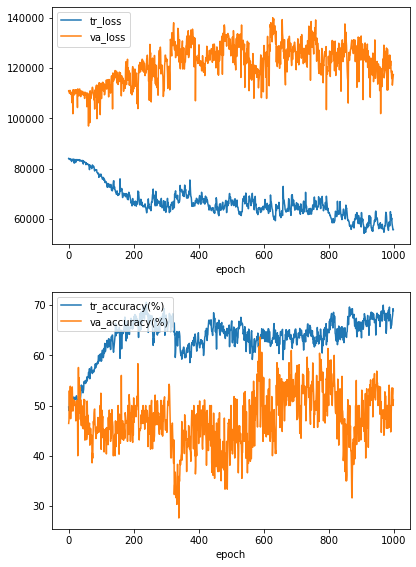

In [6]:
# sell方向モデルの学習

tr_loss_sell = []
tr_acc_sell = []
va_loss_sell = []
va_acc_sell = []

# 特徴量とラベルを[8:1:1]=[学習データ(tr):検証データ(va):テストデータ(te)]の割合で分割
tr_features, va_features, tr_y_sell, va_y_sell = train_test_split(features, y_sell, test_size=0.2, random_state=1, shuffle=False)
va_features, te_features, va_y_sell, te_y_sell = train_test_split(va_features, va_y_sell, test_size=0.5, random_state=1, shuffle=False)

# パラメータ
batchsize = 20
lr = 0.01
epochs = 1000

# 学習データをミニバッチに分割してイテレーターにする
dataset = MyDataset(tr_features, tr_y_sell)
trainloader = DataLoader(dataset, batch_size = batchsize, shuffle=True, drop_last = True)
# 検証データをミニバッチに分割してイテレーターにする
dataset = MyDataset(va_features, va_y_sell)
validloader = DataLoader(dataset, batch_size = batchsize, shuffle=True, drop_last = True)

# モデル，最適化関数，評価関数を呼び出す
model_sell = LSTM_Linear(inputDim=len(features_col), hiddenDim=5, outputDim=1)
optimizer = optim.Adam(model_sell.parameters(),lr=lr)
criterion = nn.MSELoss()

# 指定したエポック数だけ学習させる．また，学習過程における学習データと検証データの損失とTrue Positiveの割合を表示する．
for epoch in range(1, epochs+1):
    loss, acc = train(model_sell)
    print('--------------------------------------------------')
    print('Epoch is', epoch)
    print('training_loss is', loss)
    print('training_accuracy(%) is', acc)
    tr_loss_sell.append(loss)
    tr_acc_sell.append(acc)

    loss, acc = valid(model_sell)
    print('valid_loss is', loss)
    print('valid_accuracy(%) is', acc)
    va_loss_sell.append(loss)
    va_acc_sell.append(acc)

# 学習過程における学習データと検証データの損失とTrue Positiveの割合を図示する．
fig = plt.figure(figsize=(6.4, 4.8*2))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

x = [i for i in range(epochs)] 
tr_acc_sell = [None if i == 0 else i for i in tr_acc_sell]
va_acc_sell = [None if i == 0 else i for i in va_acc_sell]

ax1.plot(x, tr_loss_sell, label='tr_loss')
ax1.plot(x, va_loss_sell, label='va_loss')
ax2.plot(x, tr_acc_sell, label='tr_accuracy(%)')
ax2.plot(x, va_acc_sell, label='va_accuracy(%)')

ax1.set_xlabel('epoch')
ax2.set_xlabel('epoch')

ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper left')

plt.show()

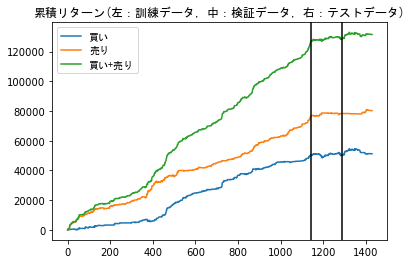

In [7]:
# 学習したモデルで実際に予測を行う

# モデルの入力にはバッチの次元が必要なのでその分を増やす
features = torch.tensor(np.expand_dims(features, 0))
y_buy = torch.tensor(np.expand_dims(y_buy, 0))
y_sell = torch.tensor(np.expand_dims(y_sell, 0))

# buy方向モデル
model_buy.eval()
pred_y_buy_list = []
y_buy_list = []

# 全データ(訓練データ+検証データ+テストデータ)を学習済みのモデルに入力する
for i in range(len(features[0])):
    pred_y_buy = model_buy(features[:,i,:,:])
    
    pred_y_buy_list.append(pred_y_buy[0,0].item())
    y_buy_list.append(y_buy[0,i,-1,0].item())

# 出力をpd.Seriesに変換する
pred_y_buy = pd.Series(data = pred_y_buy_list, name= 'pred_y_buy')
y_buy = pd.Series(data = y_buy_list, name= 'y_buy')

# sell方向モデル
model_sell.eval()
pred_y_sell_list = []
y_sell_list = []

# 全データ(訓練データ+検証データ+テストデータ)を学習済みのモデルに入力する
for i in range(len(features[0])):
    pred_y_sell = model_sell(features[:,i,:,:])
    pred_y_sell_list.append(pred_y_sell[0,0].item())
    y_sell_list.append(y_sell[0,i,-1,0].item())

# 出力をpd.Seriesに変換する
pred_y_sell = pd.Series(data = pred_y_sell_list, name= 'pred_y_sell')
y_sell = pd.Series(data = y_sell_list, name= 'y_sell')

# 予測が正の場合に注文したとして累計リターンを図示する
df_result = pd.concat([y_buy, pred_y_buy, y_sell, pred_y_sell], axis=1)
(df_result['y_buy'] * (df_result['pred_y_buy'] > 0)).cumsum().plot(label='買い')
(df_result['y_sell'] * (df_result['pred_y_sell'] > 0)).cumsum().plot(label='売り')
(df_result['y_buy'] * (df_result['pred_y_buy'] > 0) + df_result['y_sell'] * (df_result['pred_y_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.legend(prop={"family":"MS Gothic"})
plt.title('累積リターン(左：訓練データ，中：検証データ，右：テストデータ)', fontname="MS Gothic")
plt.axvline(x=len(features[0])*(8/10), color='k')
plt.axvline(x=len(features[0])*(9/10), color='k')
plt.show()

In [8]:
# 全データを使って本番用モデルを作る

# モデルの保存
# torch.save(model_buy.state_dict(), 'buy_model.pth')

# モデルの保存
# torch.save(model_sell.state_dict(), 'sell_model.pth')